# Heatmap Parameters Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../.')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np
import pandas as pd

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [10]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210510-092413
Wall time: 19.2 ms


## Analysis

Each experiment consistet of 10 images, 5 TP and 5 TN.

In [14]:
from os import listdir
from os.path import isfile, join

fpath = os.path.join(ROOT_DIR, "risei-history/heatmap-parameters--b2-value-1")

files = [f for f in listdir(fpath) if isfile(join(fpath, f))]
files[:5]

['hmap-parameters--deletion--m+1024-p1+0.25.cls',
 'hmap-parameters--deletion--m+1024-p1+0.3333333333333333.cls',
 'hmap-parameters--deletion--m+1024-p1+0.5.cls',
 'hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls',
 'hmap-parameters--deletion--m+1024-p1+0.75.cls']

In [15]:
import re


def parse(fname):
    p = re.compile("^hmap-parameters--(\w+)--m\+(\d+)-p1\+(\d+[.]?\d*)\.cls$")
    return p.match(fname).groups()

print(parse('hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls'))

('deletion', '1024', '0.6666666666666666')


In [16]:
from src.heatmaps.evaluation import HeatmapEvaluationHistory

data = {}


def append(key, value):
    if not key in data:
        data[key] = []
    data[key].append(value)

    
for fname in files:
    metric, masks_count, p1 = parse(fname)
    append('metric', metric)
    append('masks_count', int(masks_count))
    append('p1', float(p1))
    
    history = HeatmapEvaluationHistory.load(fpath, fname[:-4])
    desc = history._description()
    for key, value in desc.items():
        append(key, value)
    
    
df = pd.DataFrame(data=data)
df.head()

,metric,masks_count,p1,heatmaps,auc_mean,auc_p25,auc_median,auc_p75,auc_max,auc_min,auc_std
0,deletion,1024,0.250000,10,0.574035,0.549398,0.598989,0.624549,0.680651,0.386323,0.084330
1,deletion,1024,0.333333,10,0.547824,0.503909,0.558007,0.598945,0.642738,0.410343,0.071496
2,deletion,1024,0.500000,10,0.548105,0.517220,0.547845,0.601825,0.631686,0.436248,0.064024
3,deletion,1024,0.666667,10,0.543764,0.525023,0.574770,0.586406,0.636376,0.374856,0.075489
4,deletion,1024,0.750000,10,0.508262,0.469661,0.511021,0.541072,0.656357,0.394303,0.070623


In [17]:
def table(metric, value):
    df_m = df[df['metric'] == metric]
    df_m = df_m.sort_values('masks_count')
    return pd.pivot_table(df_m, values=value, index=["masks_count"], columns="p1", fill_value=0)

In [18]:
table('deletion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.597447,0.556259,0.530785,0.574375,0.557082
16,0.561574,0.537339,0.518918,0.545290,0.517218
32,0.621604,0.563208,0.566690,0.580131,0.596201
64,0.579971,0.554715,0.601146,0.542097,0.547473
128,0.555850,0.559322,0.569724,0.573714,0.503726
256,0.634365,0.616960,0.578741,0.547542,0.498525
512,0.597750,0.572704,0.543782,0.573382,0.527111
1024,0.598989,0.558007,0.547845,0.574770,0.511021
2048,0.604385,0.559342,0.555806,0.594506,0.523424


In [19]:
table('insertion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.577314,0.586228,0.571448,0.598190,0.598596
16,0.623005,0.601975,0.634964,0.616338,0.643950
32,0.615746,0.597924,0.592499,0.580352,0.587675
64,0.558525,0.580475,0.631789,0.616461,0.653658
128,0.605516,0.655085,0.644765,0.629008,0.644597
256,0.595822,0.591484,0.630927,0.669968,0.708476
512,0.625821,0.598811,0.627395,0.634435,0.686903
1024,0.604697,0.583369,0.629263,0.627094,0.681670
2048,0.616989,0.581046,0.613705,0.646096,0.680717


In [20]:
df_m = df.copy().sort_values("masks_count")
pd.pivot_table(df_m, values="auc_median", index=["masks_count"], columns=["p1", "metric"], fill_value=0)

p1           0.250000            0.333333            0.500000            \
metric       deletion insertion  deletion insertion  deletion insertion   
masks_count                                                               
8            0.597447  0.577314  0.556259  0.586228  0.530785  0.571448   
16           0.561574  0.623005  0.537339  0.601975  0.518918  0.634964   
32           0.621604  0.615746  0.563208  0.597924  0.566690  0.592499   
64           0.579971  0.558525  0.554715  0.580475  0.601146  0.631789   
128          0.555850  0.605516  0.559322  0.655085  0.569724  0.644765   
256          0.634365  0.595822  0.616960  0.591484  0.578741  0.630927   
512          0.597750  0.625821  0.572704  0.598811  0.543782  0.627395   
1024         0.598989  0.604697  0.558007  0.583369  0.547845  0.629263   
2048         0.604385  0.616989  0.559342  0.581046  0.555806  0.613705   
4096         0.604732  0.609865  0.560424  0.583166  0.552193  0.617107   
8192         0.601674  0.611964  0.561360  0.581889  0.548086  0.616077   
16384        0.601913  0.610840  0.560251  0.581297  0.549762  0.614958   

p1           0.666667            0.750000            
metric       deletion insertion  deletion insertion  
masks_count                                          
8            0.574375  0.598190  0.557082  0.598596  
16           0.545290  0.616338  0.517218  0.643950  
32           0.580131  0.580352  0.596201  0.587675  
64           0.542097  0.616461  0.547473  0.653658  
128          0.573714  0.629008  0.503726  0.644597  
256          0.547542  0.669968  0.498525  0.708476  
512          0.573382  0.634435  0.527111  0.686903  
1024         0.574770  0.627094  0.511021  0.681670  
2048         0.594506  0.646096  0.523424  0.680717  
4096         0.587146  0.646763  0.521934  0.694336  
8192         0.591979  0.643623  0.521773  0.679100  
16384        0.592021  0.643689  0.520736  0.679465

In [50]:
def map_p1(val):
    if val == 1/3:
        return 0.33
    if val == 2/3:
        return 0.66
    return val

def apply_fn(row):
#     print(row)
    if row['metric'] == 'deletion':
        row['auc_median'] = 1 - row['auc_median']
    row['p1'] = map_p1(row['p1'])
    return row

df_m = df.copy().sort_values("masks_count")
df_m = df_m.apply(apply_fn, axis=1)
p1_name = 'p'
masks_count_name = 'Počet masiek'
df_m = df_m.rename(columns={'p1': p1_name, 'masks_count': masks_count_name})

tt = pd.pivot_table(df_m, values="auc_median", index=[masks_count_name], columns=p1_name, fill_value=0) # value is mean of insertion and deletion auc_median
tt

p,0.25,0.33,0.50,0.66,0.75
Počet masiek,,,,,
8,0.489933,0.514984,0.520332,0.511907,0.520757
16,0.530715,0.532318,0.558023,0.535524,0.563366
32,0.497071,0.517358,0.512904,0.500110,0.495737
64,0.489277,0.512880,0.515322,0.537182,0.553093
128,0.524833,0.547881,0.537520,0.527647,0.570436
256,0.480728,0.487262,0.526093,0.561213,0.604975
512,0.514036,0.513054,0.541807,0.530526,0.579896
1024,0.502854,0.512681,0.540709,0.526162,0.585325
2048,0.506302,0.510852,0.528949,0.525795,0.578647


Text(0.5, 1.0, 'Kvalita tepelných máp metódy RISE\n(b1 = 0, b2 = 1, b2_value = 1) podľa počtu masiek\na miery prekrytia v maskách')

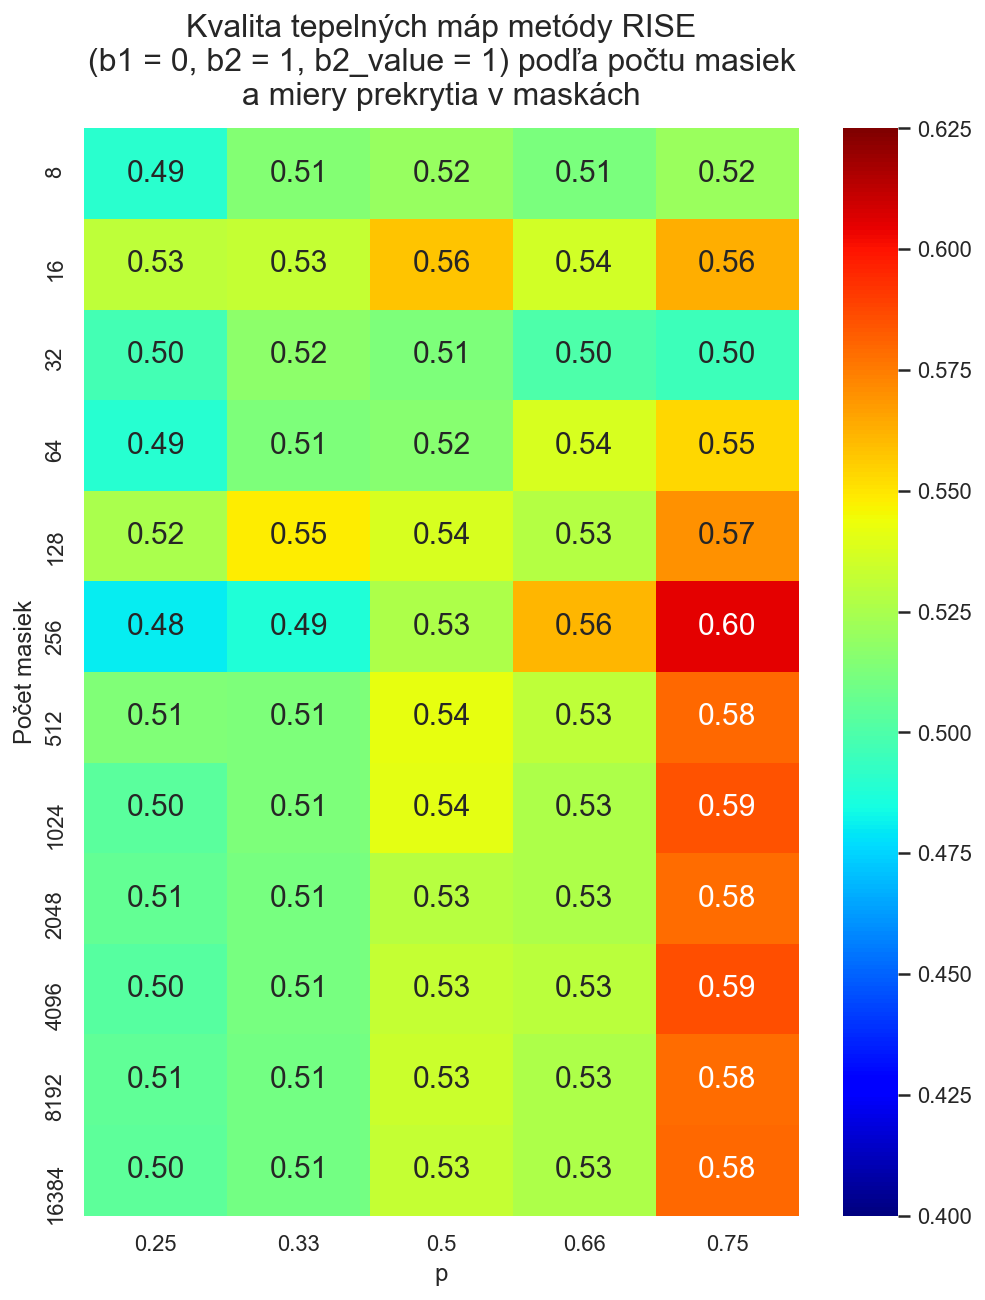

In [63]:
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['axes.titlesize'] = 16

ax = sns.heatmap(data=tt, annot=True, cmap='jet', vmin=0.40, vmax=0.625, fmt='.2f')
ax.set_title("Kvalita tepelných máp metódy RISE\n(b1 = 0, b2 = 1, b2_value = 1) podľa počtu masiek\na miery prekrytia v maskách", pad=12)